# dependencies

In [ ]:
!pip install -U "tensorflow-text==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install "tf-models-official==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=e3941658c8438bd34bc3cb1783a824ee387beed04cc319463246db3a8dcee9c7
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# prompt: read from the drive processed_data_with_outliers.csv under pfe/pfe-dataset_95

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/pfe/last_dataset_95/processed_data_with_outliers.csv')

df.shape

<ipython-input-11-091b2334cfed>:5: DtypeWarning: Columns (0,1,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/pfe/last_dataset_95/processed_data_with_outliers.csv')


(200328, 10)

In [ ]:
df.head()

,Unnamed: 0,introduction,sentence,move,sub_move,move_sub_move,is_processed,move_sub_move_gemini,short_explanation,confidence
0,0,We evaluate our approach of specializing docum...,We evaluate our approach of specializing docum...,2.0,0.0,2.0,True,-1.0,The sentence does not fit into any of the sub ...,1
1,1,We evaluate our approach of specializing docum...,Research papers in Papers with Code are labele...,0.0,1.0,0.1,True,-1.0,The sentence is an outlier because it does not...,1.0
2,2,We evaluate our approach of specializing docum...,We use these labels as aspects to specialize t...,1.0,0.0,1.0,True,-1.0,The sentence does not belong to any of the mov...,1.0
3,3,We evaluate our approach of specializing docum...,"As specialization methods, we rely on existing...",1.0,1.0,1.1,True,-1.0,The sentence describes the method and techniqu...,1.0
4,4,We evaluate our approach of specializing docum...,The specialized embeddings are compared agains...,0.0,1.0,0.1,True,1.1,The sentence highlights a gap in the field by ...,0.8


In [ ]:
df['gemini_move'] = df['move_sub_move_gemini'].apply(int)
df['sentence'] = df['sentence'].apply(lambda x: x.lower())

In [ ]:
df['gemini_move'].value_counts()

gemini_move
 2    57657
 0    56468
 1    55604
-1    30599
Name: count, dtype: int64

In [ ]:
outliers = df[df['gemini_move'] == -1]
df = df[df['gemini_move'] != -1]

In [ ]:
df.shape

(169729, 11)

In [ ]:
df['gemini_move'].value_counts()

gemini_move
2    57657
0    56468
1    55604
Name: count, dtype: int64

# select move 2 items

In [ ]:
# prompt: filter by move 2 items

df = df[df['gemini_move'] == 2]
df['gemini_move'].value_counts()

gemini_move
2    57657
Name: count, dtype: int64

In [ ]:
df['move_sub_move_gemini'].value_counts()

move_sub_move_gemini
2.0    13969
2.3    11814
2.2    11526
2.1    11403
2.4     8945
Name: count, dtype: int64

In [ ]:
# prompt: sort by move_sub_move_gemini asc

df = df.sort_values(by='move_sub_move_gemini', ascending=True)


In [ ]:
df.head()

,Unnamed: 0,introduction,sentence,move,sub_move,move_sub_move,is_processed,move_sub_move_gemini,short_explanation,confidence,gemini_move
148697,NaN,NaN,the aim of this study is to analyze the influe...,NaN,NaN,NaN,NaN,2.0,NaN,0.9,2
148654,NaN,NaN,the primary goal of this study is to examine t...,NaN,NaN,NaN,NaN,2.0,NaN,0.8,2
148657,NaN,NaN,the purpose of this study is to examine the re...,NaN,NaN,NaN,NaN,2.0,NaN,0.8,2
148659,NaN,NaN,the study aims to delve into the interplay bet...,NaN,NaN,NaN,NaN,2.0,NaN,0.8,2
850,853,"In this paper, we demonstrate that the decompr...","in this paper, we demonstrate that the decompr...",1.0,0.0,1.0,True,2.0,"The sentence states research purpose, which is...",1,2


In [ ]:
# prompt: label encode the move_sub_move_gemini column

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df["move_sub_move_gemini_encoded"] = le.fit_transform(df["move_sub_move_gemini"])

df.head()


,Unnamed: 0,introduction,sentence,move,sub_move,move_sub_move,is_processed,move_sub_move_gemini,short_explanation,confidence,gemini_move,move_sub_move_gemini_encoded
148697,NaN,NaN,the aim of this study is to analyze the influe...,NaN,NaN,NaN,NaN,2.0,NaN,0.9,2,0
148654,NaN,NaN,the primary goal of this study is to examine t...,NaN,NaN,NaN,NaN,2.0,NaN,0.8,2,0
148657,NaN,NaN,the purpose of this study is to examine the re...,NaN,NaN,NaN,NaN,2.0,NaN,0.8,2,0
148659,NaN,NaN,the study aims to delve into the interplay bet...,NaN,NaN,NaN,NaN,2.0,NaN,0.8,2,0
850,853,"In this paper, we demonstrate that the decompr...","in this paper, we demonstrate that the decompr...",1.0,0.0,1.0,True,2.0,"The sentence states research purpose, which is...",1,2,0


# bert initialization

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = [df.iloc[0]['sentence']]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1996  6614  1997  2023  2817  2003  2000 17908  1996  3747  1997]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.77882445 -0.16434832 -0.69959563  0.57480395  0.49700963 -0.16706505
  0.5379302   0.21395436 -0.50700736 -0.99961525 -0.13574596  0.64634097]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.03175185 -0.13629855 -0.11886151 ... -0.42880708  0.1836439
   0.27594104]
 [-0.2995972  -0.15872331 -0.5522966  ...  0.23818707  0.24432656
  -0.08316744]
 [-0.39070913 -0.18415174  0.02682101 ... -0.1745024  -0.02044525
  -0.13830116]
 ...
 [-0.6357619  -0.17744145 -0.2895775  ... -0.5025749  -0.54216516
   0.08838582]
 [ 0.1858551  -0.30007514 -0.45923224 ... -0.6949798  -0.6316073
   0.33787233]
 [-0.5711013  -0.02566847 -0.43329337 ... -0.21289098 -0.6809137
   0.11064148]]


In [ ]:
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
class_names = np.unique(df['move_sub_move_gemini_encoded'].to_numpy())

def create_tf_dataset_from_dataframe(data, batch_size=32, shuffle=True, seed=42):
  text = data['sentence'].to_numpy()
  labels = data['move_sub_move_gemini_encoded'].to_numpy()
   # Get unique class labels

  # One-hot encode labels
  labels = to_categorical(labels, num_classes=len(class_names))

  dataset = tf.data.Dataset.from_tensor_slices(((text), labels))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(data), seed=seed)
  dataset = dataset.batch(batch_size)
  # You can add further preprocessing steps here as needed
  return dataset

# Define training, validation, and test sets based on your split logic
# (replace this with your actual splitting logic)

train_df = df.sample(frac=0.8, random_state=seed)
val_df = df.drop(train_df.index).sample(frac=0.5, random_state=seed)
test_df = df.drop(train_df.index).drop(val_df.index)


# Create TensorFlow datasets for each split
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32  # Adjust batch size as needed
seed = 42

train_ds = create_tf_dataset_from_dataframe(train_df, batch_size=batch_size, shuffle=True, seed=seed)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = create_tf_dataset_from_dataframe(val_df, batch_size=batch_size, shuffle=False, seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = create_tf_dataset_from_dataframe(test_df, batch_size=batch_size, shuffle=False, seed=seed)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [ ]:
df.shape,test_df.shape,val_df.shape,train_df.shape

((57657, 12), (5765, 12), (5766, 12), (46126, 12))

In [ ]:
import keras


def build_classifier_model( dropout_rate=0.1):
    # Text input
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    bert_output = outputs['pooled_output']

    # Add dropout layer
    net = keras.layers.Dropout(dropout_rate)(bert_output)

    # Output layer
    net = keras.layers.Dense(  len(class_names), activation='softmax', name='classifier')(net)

    return keras.Model(inputs=text_input, outputs=net)



In [ ]:
model = build_classifier_model()
bert_raw_result = model(tf.constant(['testu']))
print(bert_raw_result)

tf.Tensor([[0.17012404 0.04271033 0.43913528 0.29873633 0.04929401]], shape=(1, 5), dtype=float32)


In [ ]:
print(class_names)
t = to_categorical(class_names, num_classes=len(class_names))
t

[0 1 2 3 4]


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

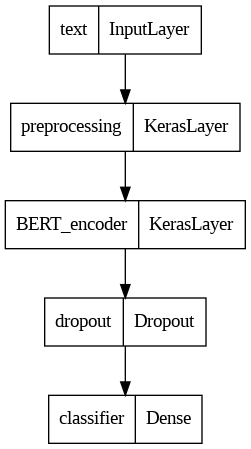

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define a callback to save model checkpoints
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      save_best_only=True,  # Save only the best model
                                      monitor='val_loss',   # Monitor validation loss
                                      mode='min')           # Minim
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
print(class_names)
print(len(class_names))
df.shape


[0 1 2 3 4]
5


(57657, 12)

In [ ]:
  loss = keras.losses.CategoricalCrossentropy()
  METRICS= [
      keras.metrics.F1Score(name='f1_average'),


  ]

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS

                         )

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,callbacks=[checkpoint_callback,early_stopping_callback],
                               workers=8,
                               use_multiprocessing=True

                               )

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2
1442/1442 [==============================] - ETA: 0s - loss: 0.2396 - f1_average: 0.9233

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1442/1442 [==============================] - 1330s 912ms/step - loss: 0.2396 - f1_average: 0.9233 - val_loss: 0.1482 - val_f1_average: 0.9561
Epoch 2/2
1442/1442 [==============================] - 1317s 913ms/step - loss: 0.1109 - f1_average: 0.9675 - val_loss: 0.1382 - val_f1_average: 0.9605


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

181/181 [==============================] - 56s 309ms/step - loss: 0.1420 - f1_average: 0.9591
Loss: 0.1419808566570282
Accuracy: [0.95352113 0.9730701  0.9418803  0.9353319  0.99160606]


dict_keys(['loss', 'f1_average', 'val_loss', 'val_f1_average'])


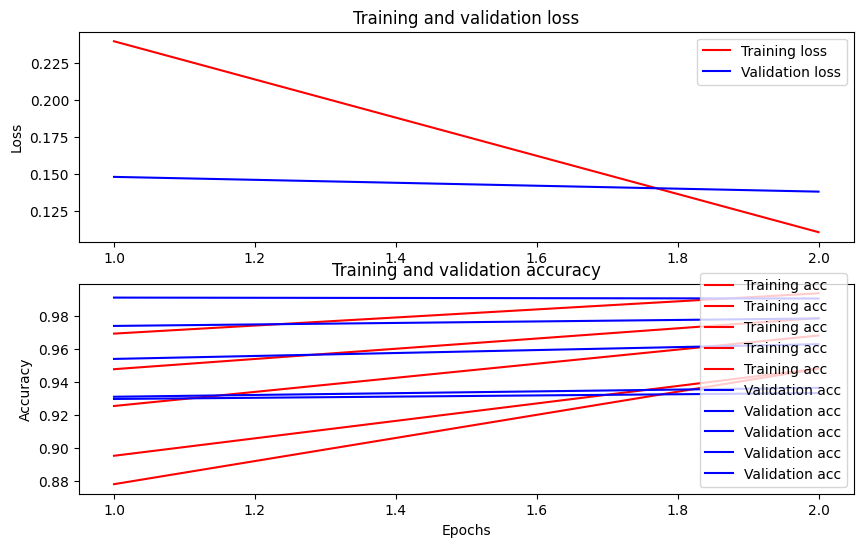

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['f1_average']
val_acc = history_dict['val_f1_average']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imrad-moves-dataset'
saved_model_path = '/content/drive/MyDrive/pfe/last_dataset_95/model_move_2_submoves_epoch_2/{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = keras.models.load_model(saved_model_path)

In [ ]:
epochs

range(1, 3)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history1 = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=2+1,callbacks=[checkpoint_callback,early_stopping_callback],
                               workers=8,
                               use_multiprocessing=True,
                               initial_epoch=2

                               )

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 3/3
4244/4244 [==============================] - 3921s 924ms/step - loss: 0.0231 - f1_average: 0.9930 - val_loss: 0.0612 - val_f1_average: 0.9833
